# Regression Vission Transformer

- Solo usamos la parte de Transformer Encoder

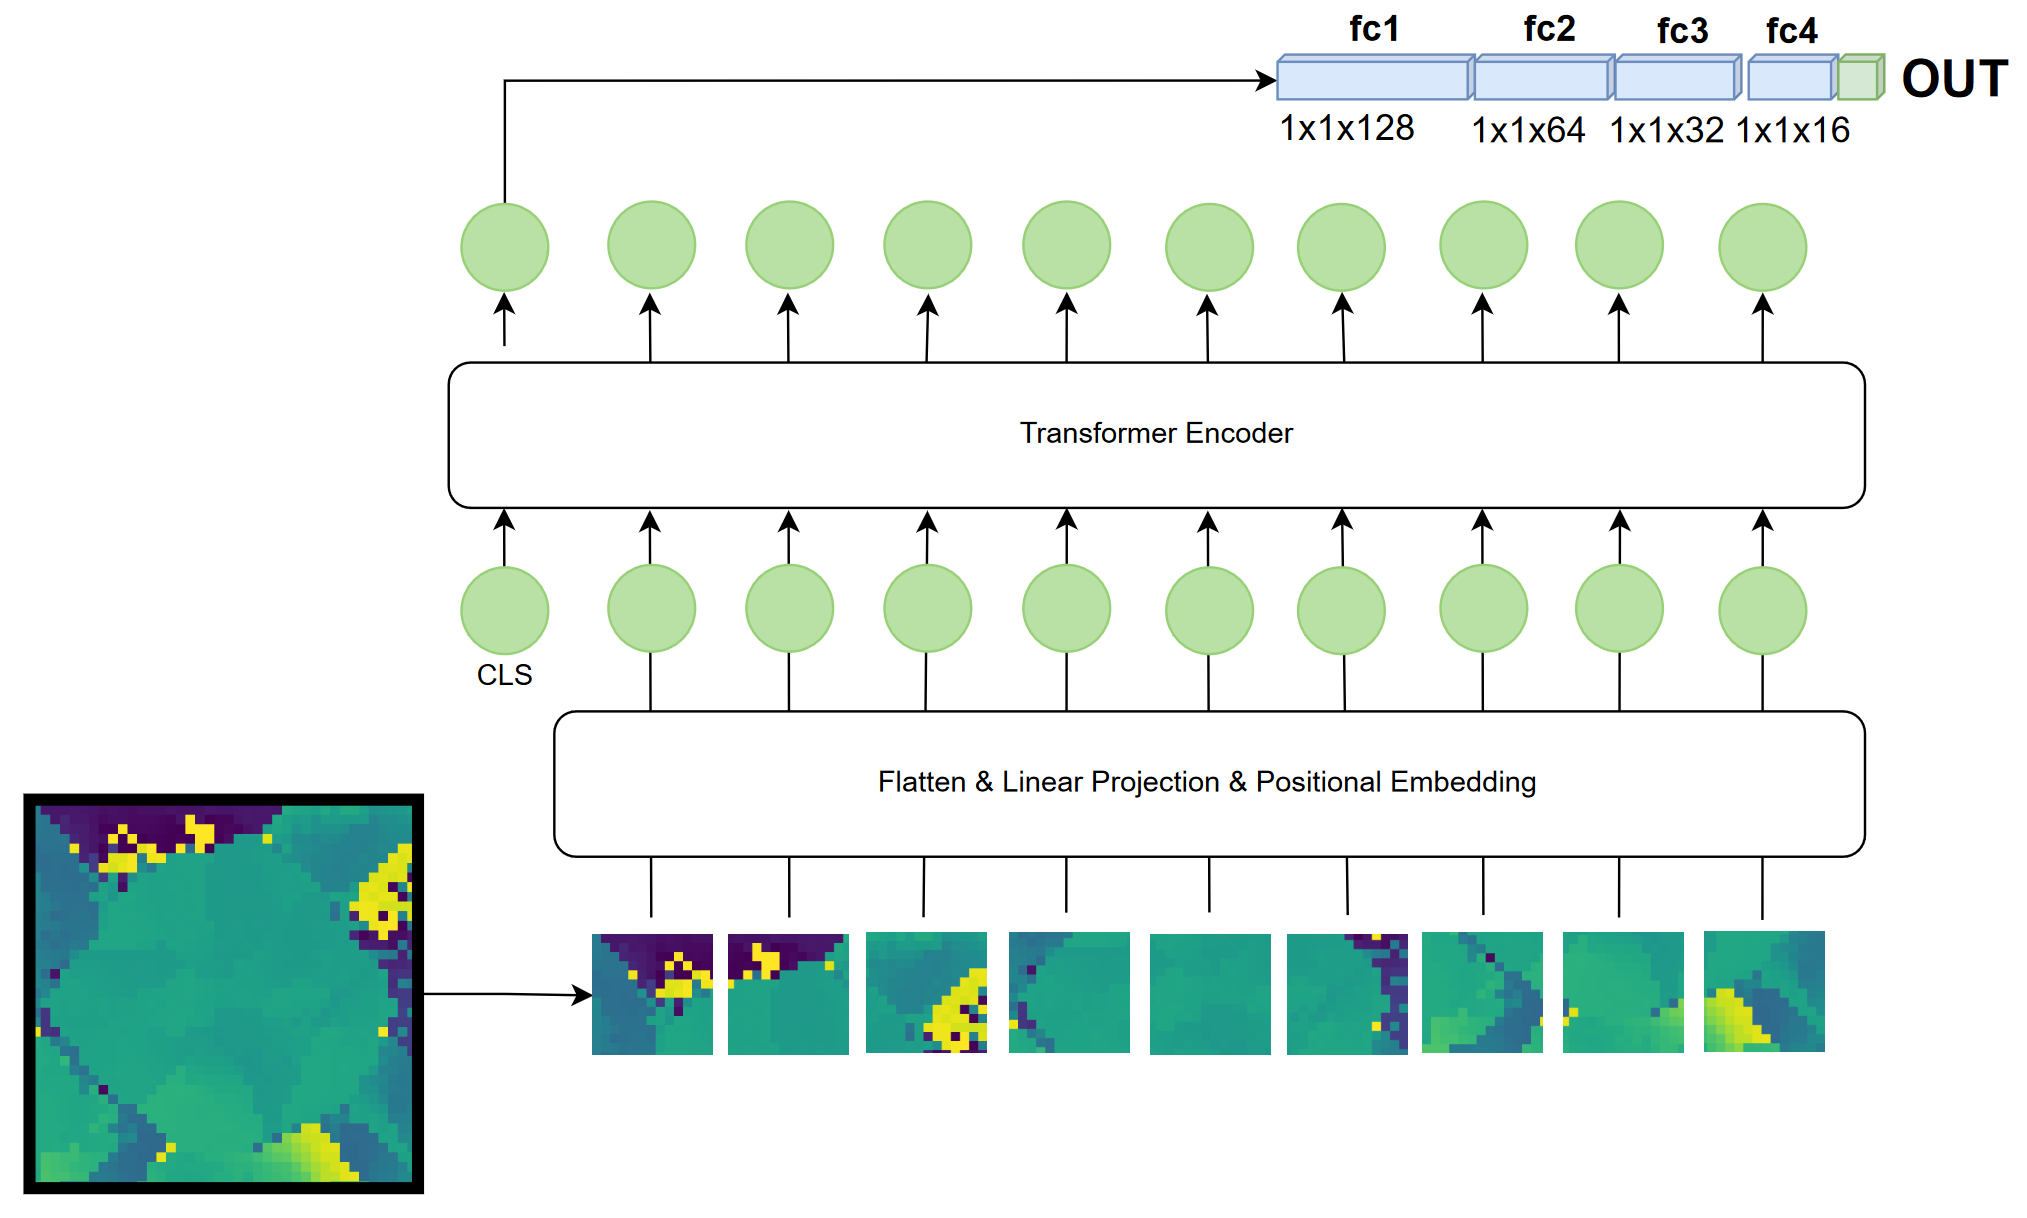

## Imports


In [ ]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate, AveragePooling2D, Concatenate
from keras.utils import plot_model
#from imblearn.over_sampling import RandomOverSampler

import keras.ops as ops


#Models of TINTOlib
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Processing

### Read the dataset

In [150]:
dataset_name = 'boston'

#Read CSV
df = pd.read_csv(f"../resources/Datasets/{dataset_name}.csv")
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [118]:
df.shape

(506, 14)

- Extrameos cual será el tamaño cuadrático de la imagen

In [119]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


### Create images with TINTOLib

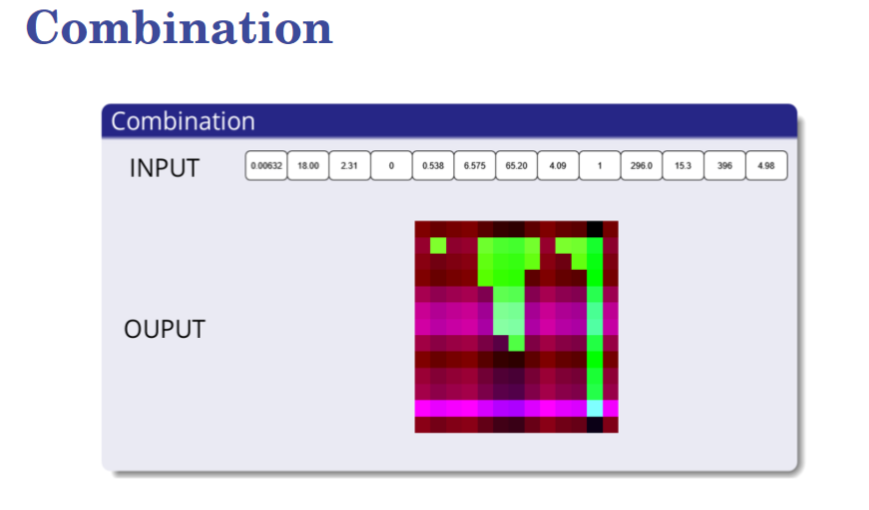

In [120]:
#Select the model and the parameters
#problem_type = "supervised"
problem_type = "regression"

# Transformation methods
image_model = Combination(problem=problem_type, zoom=3)
name = f"Combination"


#Define the dataset path and the folder where the images will be saved
results_folder = f"Results/{dataset_name}_{name}"
images_folder = f"Synthetic_images/images_{dataset_name}_{name}"

## Generate images

In [121]:
import cv2
from sklearn.preprocessing import MinMaxScaler

X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [122]:
def process_dataset(X, folder_name, generate_function, problem_type):
    """
    Handles dataset processing, including image generation, path updates, 
    and combining the dataset with image paths.

    Parameters:
    ----------
    X : DataFrame
        The dataset to process (training, validation, or test).
    
    folder_name : str
        The name of the folder where generated images will be stored 
        (e.g., 'train', 'val', 'test').
    
    generate_function : function
        The function used for training and generating images. It can be one of the following:
        - `fit`: Trains the model without generating images.
        - `fit_transform`: Trains the model and generates images for the dataset (used for training).
        - `transform`: Uses the pre-trained model to generate images for validation and testing.
    
    problem_type : str
        The type of problem being addressed (e.g., regression, supervised).
        This is used to locate the corresponding `.csv` file containing image paths.

    Returns:
    --------
    X_processed : DataFrame
        The dataset with updated image paths and raw tabular data, ready for further processing.
    
    y_processed : Series
        The labels corresponding to the dataset (target values).
    """
    # Generate the images if the folder does not exist
    folder_path = f"{images_folder}/{folder_name}"
    if not os.path.exists(folder_path):
        generate_function(X, folder_path)
    else:
        print(f"The images for {folder_name} are already generated")

    # Load image paths
    img_paths = os.path.join(folder_path, f"{problem_type}.csv")
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = folder_path + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X], axis=1)

    # Split data and labels
    X_processed = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_processed = combined_dataset["values"]

    return X_processed, y_processed


In [123]:
### X_train
X_train, y_train = process_dataset(X_train, "train", image_model.fit_transform, problem_type)

In [124]:
### X_val
X_val, y_val = process_dataset(X_val, "val", image_model.transform, problem_type)

In [125]:
### X_test
X_test, y_test = process_dataset(X_test, "test", image_model.transform, problem_type)

## Pre-modeling

In [126]:
#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width, channels = X_train_img[0].shape
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (39, 39, 3)
Attributres:  13
Image size (pixels): 39


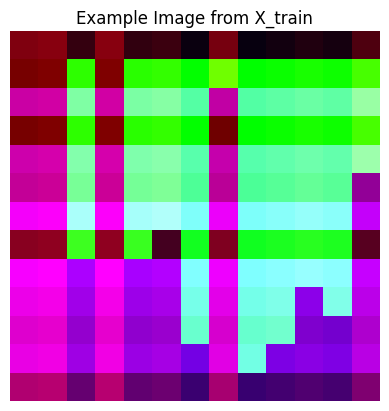

In [127]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

In [128]:
# Normalitation
X_train_num

array([[0.06108607, 0.        , 0.64662757, ..., 0.80851064, 0.89507792,
        0.4415011 ],
       [0.00251062, 0.        , 0.37133431, ..., 0.63829787, 0.99488123,
        0.25496689],
       [0.012639  , 0.        , 0.28152493, ..., 0.89361702, 0.90738313,
        0.575883  ],
       ...,
       [0.00155603, 0.        , 0.35007331, ..., 0.55319149, 0.98638358,
        0.32781457],
       [0.06390286, 0.        , 0.64662757, ..., 0.80851064, 0.98935902,
        0.3656181 ],
       [0.05714125, 0.        , 0.64662757, ..., 0.80851064, 0.97022038,
        0.42880795]])

## Modeling ViT

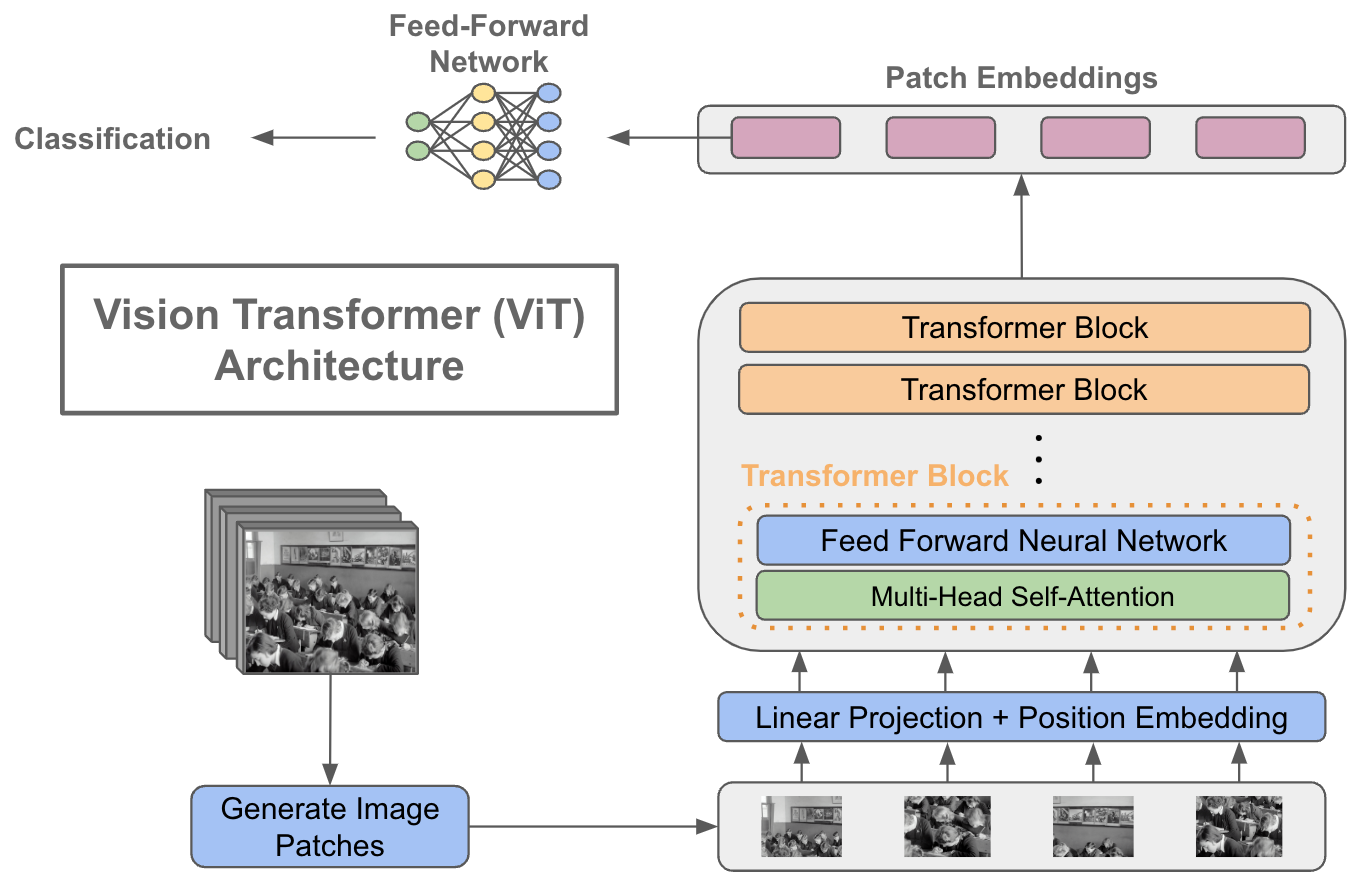

- Buscamos el tamaño de batch que podemos utilizar

In [129]:
def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:  # Check to include both divisors if they are not the same
                divisors.append(n // i)
    divisors.sort()
    return divisors

In [130]:
find_divisors(imgs_shape[1])

[1, 3, 13, 39]

This code defines the hyperparameters for the ViT model implemented. The hyperparameters are as follows:

- `image_size`: input image size.
- `patch_size`: size of the patches extracted from the images.
- `num_patches`: total number of patches extracted from each image.
- `projection_dim`: dimensionality of the linear projection for the patches.
- `num_heads`: number of attention heads in the transformer.
- `transformer_units`: list of units in the transformer layers.
- `transformer_layers`: number of layers in the transformer.
- `mlp_head_units`: list of units in the dense layers of the final classifier.

These hyperparameters are used to configure the ViT model and its training process.

In [131]:
pixel

39

In [132]:
# Params
image_size = pixel
patch_size = 3
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [
    128,
    64,
]

## Patches Class


The `Patches` class divides an image into small, fixed-size patches, rearranging them into a tensor that can be used as input for a Vision Transformer. This is essential because Transformers work with sequences, and this class converts images into sequences of patches.

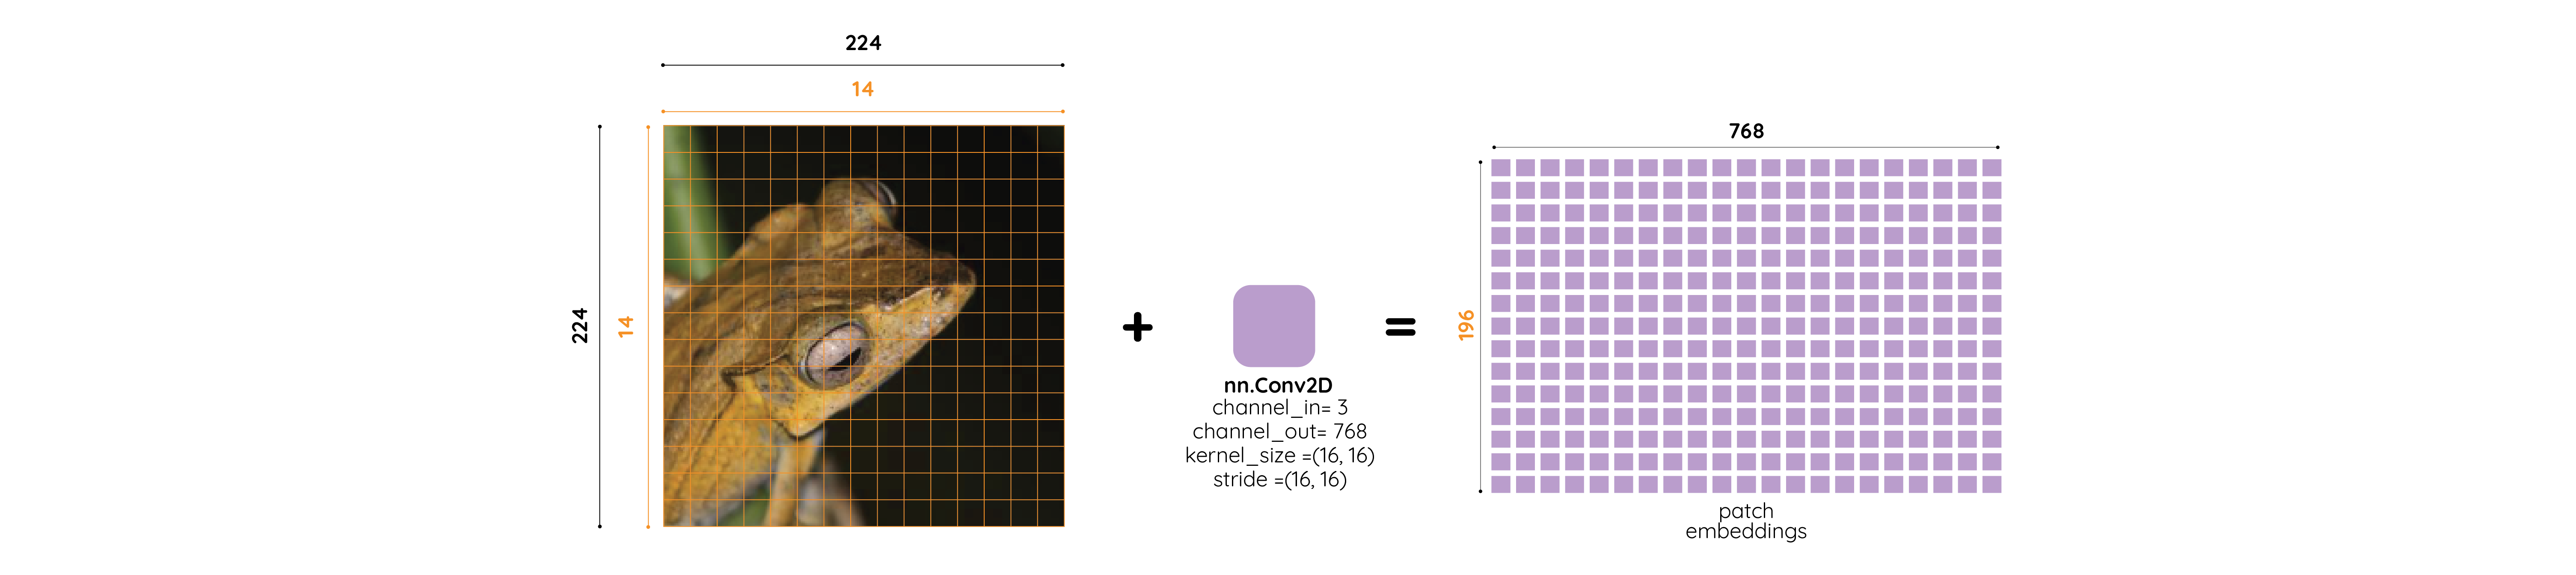

The `Patches` class is a subclass of `layers.Layer` in Keras, meaning it is a custom layer. This class is responsible for dividing an image into small patches that will be used as inputs to the Vision Transformer.

##### `__init__` Constructor
- `__init__` is the class constructor.
- `patch_size` is a parameter that specifies the size of each patch into which the image will be divided.
- `super().__init__()` calls the constructor of the base class (`layers.Layer`), initializing the layer.

##### `call` Method
- `call` is the method that defines the logic of the layer. It is invoked when a tensor (in this case, images) is passed through the layer.
- `input_shape = ops.shape(images)` retrieves the shape (dimensions) of the input tensor `images`. Assuming `images` is a 4D tensor (batch, height, width, channels).
- `batch_size`, `height`, `width`, and `channels` extract the respective dimensions of the image.
- `num_patches_h` and `num_patches_w` calculate the number of patches in the height and width of the image, respectively, by dividing the corresponding dimension by `patch_size`.
- `patches = keras.ops.image.extract_patches(images, size=self.patch_size)` uses a Keras function to extract patches of size `patch_size` from the input images.
- `patches = ops.reshape(...)` reshapes the `patches` tensor to have the shape `(batch_size, num_patches_h * num_patches_w, patch_size * patch_size * channels)`. This means that each patch is flattened and organized into a sequence of patches.

##### `get_config` Method

- `get_config` is a standard method in Keras for custom layers. It allows the layer's configuration to be saved and reloaded.
- `config = super().get_config()` calls the base class's `get_config` method to retrieve the basic configuration of the layer.
- `config.update({"patch_size": self.patch_size})` adds the `patch_size` to the configuration.
- `return config` returns the complete configuration.

In [133]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


## Patches Class

The `PatchEncoder` class takes the image patches and projects them into a higher-dimensional space using a dense layer (`Dense`). It then adds positional information to each patch using a positional embedding layer (`Embedding`). This encoding is crucial for the functioning of Transformers, which need to know both the content of the patches and their position in the original image.

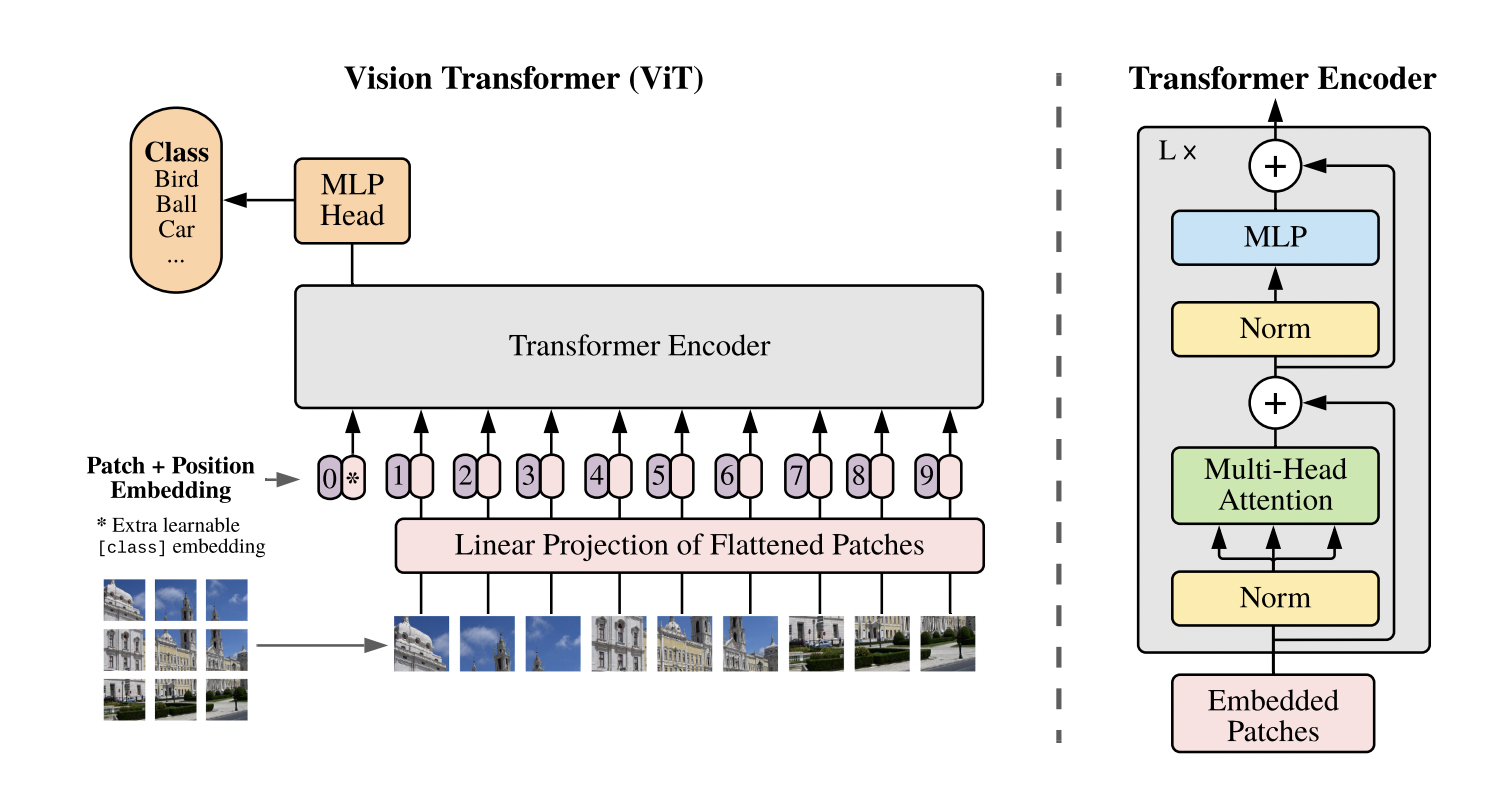

The `PatchEncoder` class is a subclass of `layers.Layer` in Keras, and it is used to project and encode the image patches.

##### `__init__` Constructor
- `__init__` is the class constructor.
- `num_patches` is the total number of patches into which the image has been divided.
- `projection_dim` is the dimension into which the patches will be projected.
- `self.projection` is a `Dense` layer that projects each patch into a higher-dimensional space specified by `projection_dim`.
- `self.position_embedding` is an `Embedding` layer that creates positional embeddings for each patch, with `num_patches` as the vocabulary size and `projection_dim` as the output dimension.

##### `call` Method
- `call` is the method that defines the logic of the layer. It is invoked when a tensor (in this case, patches) is passed through the layer.
- `positions` creates a tensor with a sequence of positions (from 0 to `num_patches - 1`), expanding the dimension to match the batch of data.
- `projected_patches` applies a linear projection to each patch using the `Dense` layer, resulting in a higher-dimensional tensor.
- `encoded` adds the linear projection of the patches (`projected_patches`) to the positional embeddings (`self.position_embedding(positions)`). This sum incorporates information about the position of each patch, which is crucial for the Transformer to understand the spatial arrangement of the patches.
- `return encoded` returns the encoded tensor.

##### `get_config` Method
- `get_config` is a standard method in Keras for custom layers. It allows the layer's configuration to be saved and reloaded.
- `config = super().get_config()` calls the base class's `get_config` method to retrieve the basic configuration of the layer.
- `config.update({"num_patches": self.num_patches})` adds `num_patches` to the configuration.
- `return config` returns the complete configuration.

In [134]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

## Classifier

The `mlp` function constructs an MLP that transforms the input tensor `x` through several dense and dropout layers. Each dense layer applies a linear transformation followed by a `gelu` activation, and each dropout layer randomly deactivates a percentage of the units from the previous layer to improve model generalization. This function is useful for adding non-linear learning capacity to the model, allowing it to capture more complex relationships in the data:
- `x`: the input tensor to be transformed.
- `hidden_units`: a list specifying the number of units (neurons) in each hidden layer of the MLP network.
- `dropout_rate`: the dropout rate applied after each dense layer, helping to prevent overfitting.

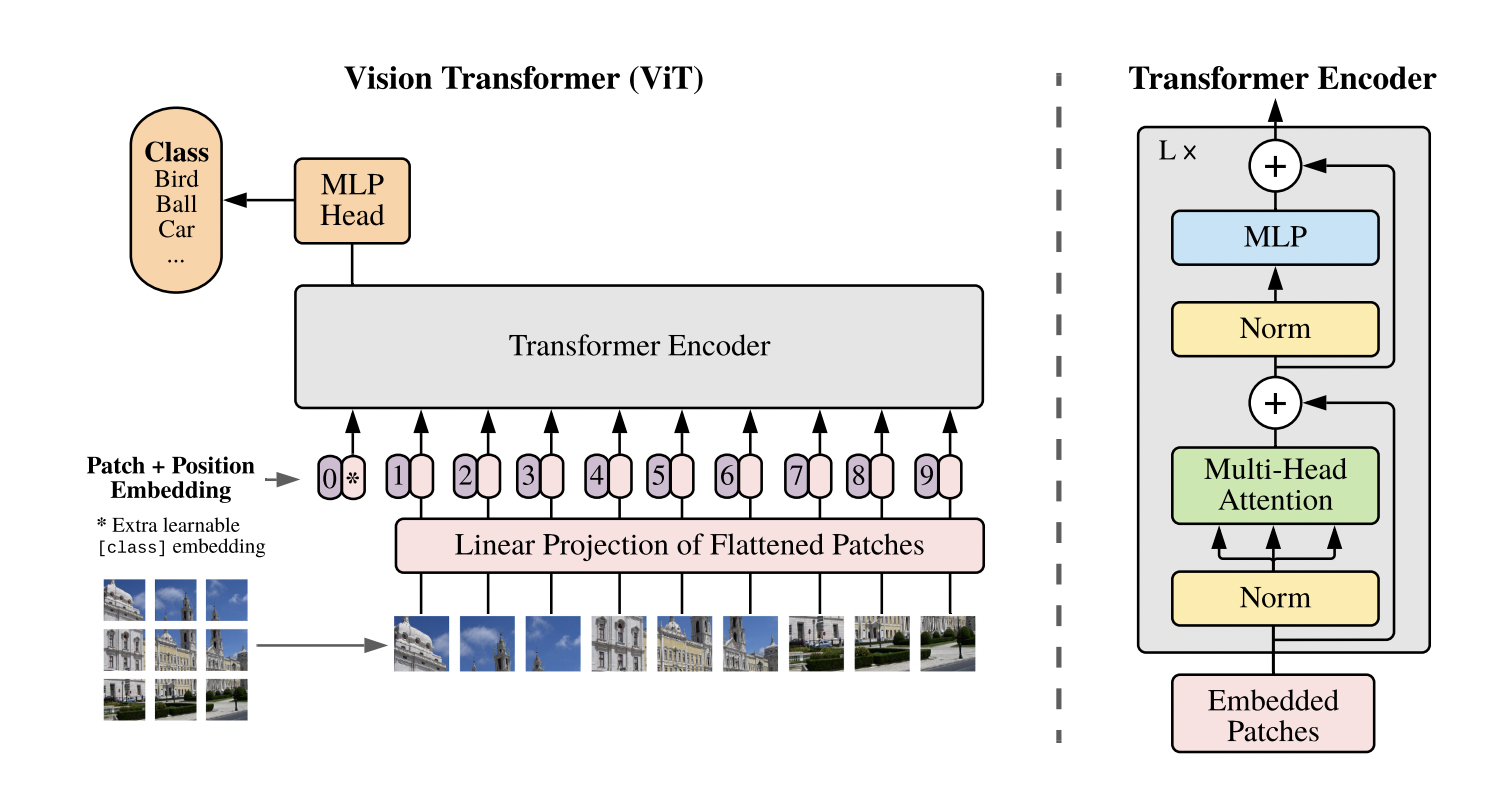

In [135]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## ViT Classifier

The `create_vit_classifier` function constructs a complete Vision Transformer classifier.
1. It first divides the input image into patches and encodes those patches.
2. Then, it passes the encoded patches through multiple Transformer layers, each of which includes layer normalization, multi-head attention, residual connections, and MLP layers.
3. Finally, it normalizes and flattens the representation before passing it through a final MLP network to produce the output features.

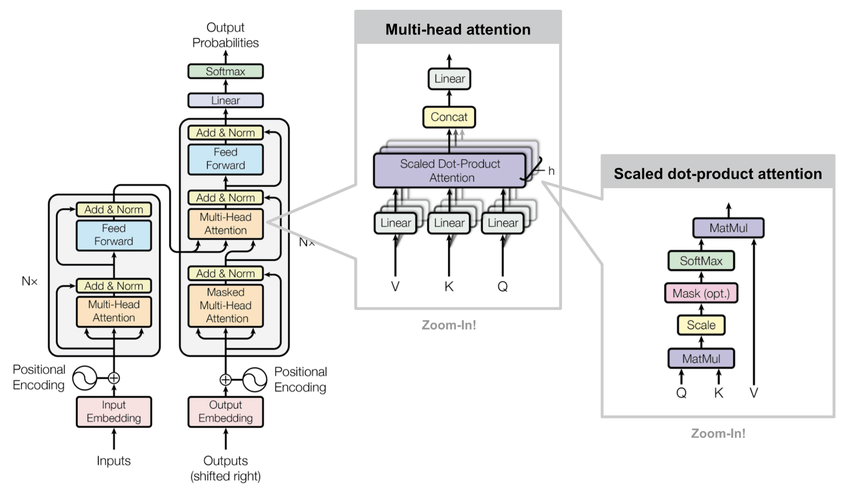

#### Model Input
- `inputs`: defines the model input with a shape specified by `input_shape`.

#### Patch Creation
- `patches`: instantiates the `Patches` layer (defined earlier) to divide the input image into smaller patches of the size specified by `patch_size`.

#### Patch Encoding
- `encoded_patches`: instantiates the `PatchEncoder` layer (defined earlier) to project the patches into a high-dimensional space and add positional embeddings.

#### Transformer Blocks
- Loops through `transformer_layers` to create multiple layers of the Transformer block.
    - `x1`: applies layer normalization to the `encoded_patches`.
    - `attention_output`: applies a multi-head attention layer.
    - `x2`: performs a residual (skip) connection by adding `attention_output` and `encoded_patches`.
    - `x3`: applies another layer normalization to `x2`.
    - `x3`: passes through an MLP using the `mlp` function defined earlier.
    - `encoded_patches`: performs another residual connection by adding `x3` and `x2`.

#### Final Representation
- `representation`: applies layer normalization, flattens the tensor, and applies dropout for regularization.

#### Final MLP Network
- `features`: applies another MLP to the final representation.

In [136]:
def create_vit_classifier():
    inputs = keras.Input(shape=imgs_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.1)(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=representation)
    return model

In [137]:
vit_model = create_vit_classifier()

## MLP

In [138]:
output = vit_model.output
x = Dense(128, activation="relu")(output)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs=[vit_model.input], outputs=x)

## Metrics

In [139]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

- Print the hybrid model

In [140]:
os.makedirs(results_folder, exist_ok=True)

# Redirect the summary output to the specified file
with open(results_folder+"/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Desactivar la visualización automática de matplotlib
plt.ioff()
# Now, you can also save the model plot
plot_model(model, to_file=results_folder+'model_plot.png', show_shapes=True, expand_nested=True)
# Reactivar la visualización automática de matplotlib (opcional)
plt.ion()

## Compile

In [141]:
opt = Adam(learning_rate=1e-4)

In [142]:
model.compile(
    loss="mse",
    optimizer=opt,
    metrics = METRICS
)

In [143]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=10,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [144]:
model_history=model.fit(
    x=[X_train_img], y=y_train,
    validation_data=([X_val_img], y_val),
    epochs=50,
    batch_size=16,
    callbacks = [early_stopper]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - loss: 459.3364 - mae: 19.2930 - mse: 459.3364 - r_square: -6.8800 - rmse: 21.2891 - val_loss: 79.5409 - val_mae: 6.6992 - val_mse: 79.5409 - val_r_square: -1.2537 - val_rmse: 8.9186
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 84.4252 - mae: 6.2202 - mse: 84.4252 - r_square: -0.0782 - rmse: 9.0473 - val_loss: 46.6643 - val_mae: 5.5530 - val_mse: 46.6643 - val_r_square: -0.4584 - val_rmse: 6.8311
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 55.4171 - mae: 5.3218 - mse: 55.4171 - r_square: 0.2314 - rmse: 7.4015 - val_loss: 40.4083 - val_mae: 5.3689 - val_mse: 40.4083 - val_r_square: -0.8594 - val_rmse: 6.3568
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 49.5498 - mae: 5.0835 - mse: 49.5498 - r_square: 0.2783 - rmse: 7.0091 - val_loss: 36.9640 - val_mae: 5.1181 - val_mse: 36.9640 - val_r_square: -0.7385 - val_rmse: 6.0798
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 43.1599 - mae

In [145]:
print(model_history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'r_square', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r_square', 'val_rmse'])


## Results

### Train/Validation representation

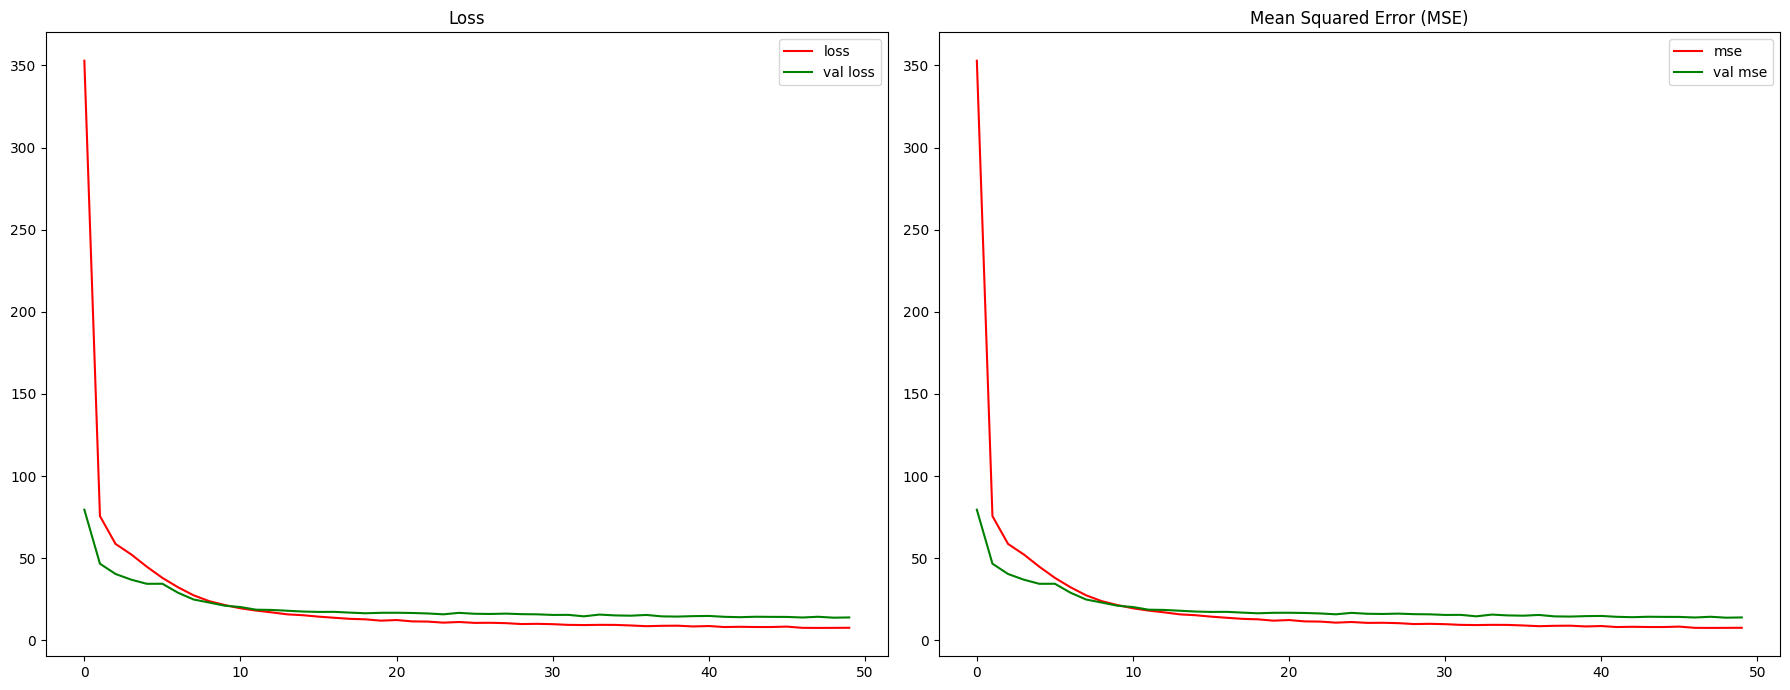

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 fila, 2 columnas

# Subplot 1: Loss
axes[0].plot(model_history.history['loss'], color='red', label='loss')
axes[0].plot(model_history.history['val_loss'], color='green', label='val loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

# Subplot 2: MSE
axes[1].plot(model_history.history['mse'], color='red', label='mse')
axes[1].plot(model_history.history['val_mse'], color='green', label='val mse')
axes[1].set_title('Mean Squared Error (MSE)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Train/Validation evaluation

In [147]:
score_test = model.evaluate([X_val_img], y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 13.7442 - mae: 2.8818 - mse: 13.7442 - r_square: 0.7330 - rmse: 3.7073 


In [148]:
prediction = model.predict([X_test_img])

test_mape = mean_absolute_percentage_error(y_test, prediction)
test_mae = mean_absolute_error(y_test, prediction)
test_mse = mean_squared_error(y_test, prediction)
test_rmse = root_mean_squared_error(y_test, prediction)
test_r2 = r2_score(y_test, prediction)

# Print the evaluation metrics
print("Mean Absolute Percentage Error:", test_mape)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("R2 Score:", test_r2)

# Define the metrics and their values
metrics = {
    "Mean Absolute Percentage Error": test_mape,
    "Mean Absolute Error": test_mae,
    "Mean Squared Error": test_mse,
    "Root Mean Squared Error": test_rmse,
    "R2 Score": test_r2,
}

# Save the metrics to a text file
with open(f"{results_folder}/metrics.txt", "w") as file:
    for metric, value in metrics.items():
        file.write(f"{metric}: {value}\n")

print(f"Metrics saved to {results_folder}/metrics.txt")

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f60644e5240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Mean Absolute Percentage Error: 0.1058575060909857
Mean Absolute Error: 2.279400732003006
Mean Squared Error: 11.004265177742381
Root Mean Squared Error: 3.317267727775734
R2 Score: 0.8963448788652604
Metric

In [149]:
train_mse = model_history.history["mse"][-1]
train_r2 = model_history.history["r_square"][-1]

val_mse = model_history.history["val_mse"][-1]
val_r2 = model_history.history["val_r_square"][-1]

print("Train Mean Squared Error:", train_mse)
print("Train R2 Score:", train_r2)

print("Val Mean Squared Error:", val_mse)
print("Val R2 Score:", val_r2)

Train Mean Squared Error: 7.65854024887085
Train R2 Score: 0.8857949376106262
Val Mean Squared Error: 13.951675415039062
Val R2 Score: 0.6132753491401672
